### Technical Report 
*Problem Statement, Data, EDA, Image preprocessing*

[Problem & Goals](#a) | [Data](#2) | [EDA](#3) | [Image preprocessing](#4) | [Model](aws_pizza_classifier_keras.ipynb) | [Results](model.ipynb) | [Summary](model.ipynb)

In [51]:
# standard imports
import os, glob, fnmatch, pickle, itertools
import pandas as pd
import numpy as np

# image processing imports
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# modeling imports
from keras.models import model_from_json

# classification metrics imports
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, confusion_matrix, \
accuracy_score, precision_score, recall_score

# plotting imports
import seaborn as sns
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib import cm as cm
%matplotlib inline

### Functions

In [2]:
def img_plots(fig_h, path_list, label_df, x_label, variable_df, plot_title):
    sns.set_style("white")
    fig, ax = plt.subplots(1,5,figsize=(16,fig_h))
    
    images_plot = []
    
    for img in path_list[:5]:
        image = cv2.imread(img)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images_plot.append(image_rgb)
    
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(images_plot[i])
        label = 'not pizza' if label_df.values[i] == 0 else 'pizza'
        plt.title(label, size=16)
        plt.xlabel(x_label + "\n%.3f" % variable_df.values[i], size=14)
        plt.suptitle(plot_title, size=18)
    plt.show()   

In [ ]:
def epoch_plot():
    # A plot of accuracy on the training and validation datasets over training epochs.
    sns.set_style("dark")
    plt.figure(figsize=(20, 6))

    plt.subplot(1,2,1)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('Model accuracy', size=18)
    plt.ylabel('Accuracy', size=16)
    plt.xlabel('Epoch', size=16)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=13)

    # A plot of loss on the training and validation datasets over training epochs.
    plt.subplot(1,2,2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss', size=18)
    plt.ylabel('Loss', size=16)
    plt.xlabel('Epoch', size=16)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=13)

    plt.show()

---

## <a name="a">Problem & Goals</a>

Ever wonder if there is pizza in your immediate surroundings? Of course — that's a totally normal human emotion. And that's where the Pizza Detector™ comes to the rescue. 

The goal of this project is to first develop & train a model that recognizes a specific food category (in this case pizza, because why not pizza?) from a single image of that particular food. A longer term goal would be to expand the model to be a multi-label classifier that recognizes many other food categories and then ultimately predicts calories and other nutritional info from a photo.

On a more serious note, tracking food intake for weight loss or to manage medical conditions (ie diabets, food allergies, etc) can be fairly labor intensive (and frankly annoying) as it usually requires manually entering nutritional info into a fitness/food tracking app. Because of this, most people don't stick with tracking their food intake for very long and this can potentially lead to weight gain and other health problems.



---

## <a name="2">Data</a>

The data set is comprised of 2,000 food photos that are labeled "not pizza" plus 2,000 photos labeled "pizza" that come from randomly sampling [The Food-101 Data Set](https://www.vision.ee.ethz.ch/datasets_extra/food-101/) (and supplementing with an additional 1,000 photos of pizza from [ImageNet](http://image-net.org/synset?wnid=n07873807)). The The Food-101 Data Set dataset includes a 101 food categories, with 1,000 images per category taken from [Foodspotting.com](http://www.foodspotting.com/). The data set still contains some noise — mostly in the form of intense colors and sometimes wrong labels. 

In [3]:
path = '/Users/VanessaG/Desktop/DSI-SF-2-vnessified/capstone/data_sources/food-101/images'
food_categories = {}
folders = os.listdir(path)
for folder in folders[2:]:
    food_categories[folder] = len(os.listdir(os.path.join(path,folder)))
print food_categories

{'churros': 1000, 'hot_and_sour_soup': 1000, 'samosa': 1000, 'sashimi': 1000, 'pork_chop': 1000, 'spring_rolls': 1000, 'panna_cotta': 1000, 'beef_tartare': 1000, 'greek_salad': 1000, 'foie_gras': 1000, 'tacos': 1000, 'pad_thai': 1000, 'poutine': 1000, 'ramen': 1000, 'pulled_pork_sandwich': 1000, 'bibimbap': 1000, 'beignets': 1000, 'apple_pie': 1000, 'crab_cakes': 1000, 'risotto': 1000, 'paella': 1000, 'steak': 1000, 'baby_back_ribs': 1000, 'miso_soup': 1000, 'frozen_yogurt': 1000, 'club_sandwich': 1000, 'carrot_cake': 1000, 'falafel': 1000, 'bread_pudding': 1000, 'chicken_wings': 1000, 'gnocchi': 1000, 'caprese_salad': 1000, 'creme_brulee': 1000, 'escargots': 1000, 'chocolate_cake': 1000, 'tiramisu': 1000, 'spaghetti_bolognese': 1000, 'mussels': 1000, 'scallops': 1000, 'baklava': 1001, 'edamame': 1000, 'macaroni_and_cheese': 1000, 'pancakes': 1000, 'garlic_bread': 1000, 'beet_salad': 1000, 'onion_rings': 1000, 'red_velvet_cake': 1000, 'grilled_salmon': 1000, 'chicken_curry': 1000, 'dev

---

## <a name="3">Data cleaning & munging</a>
Because the data is all image based in the form of pixels, the concept of "cleaning" isn't really applicable. It does make sense to employ standardizaiton techniques to adjust for differences in lighting and other artifacts caused by different camera types, etc used in the photography of the food items. I used the Keras `ImageDataGenerator` class  to do this in the [Image preprocessing](#4) section following EDA.   

However, I do some light data manipulation and munging using OpenCV methods to explore the relationshop between RGB & HSV values on pizza vs non pizza images. First I read in each image with `cv2.imread()`, normalize with `cv2.normalize()` — this divides each pixel's value by the sum of the pixels value over all channels which removes distortions caused by lights and shadows in an image. Then using `cv2.mean()` I calculate the mean  RGB and HSV values for each image returning tuples from `cv2.cvtColor()` using `cv2.COLOR_BGR2RGB` and `cv2.COLOR_BGR2HSV` respectively. I created a dataframe from the color values and add height, width and total pixels just for good measure (since images are represented by numpy arrays, using `.shape` gives pixel height, width and 3 color channels).

In [4]:
img_info = pd.read_csv('image_info.csv', index_col=0)
img_info.head()

,label,red,green,blue,hue,sat,val,img_height,img_width,total_px,short_path,full_path
0,0,0.232010,0.121889,0.040963,36.224313,0.808038,0.232448,512,384,196608,train/not_pizza/10060.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
1,0,0.637750,0.452795,0.490195,205.991908,0.468141,0.679158,512,512,262144,train/not_pizza/1008028.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
2,0,0.398433,0.340697,0.371352,175.903364,0.374069,0.461239,512,512,262144,train/not_pizza/1008185.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
3,0,0.584648,0.307440,0.103829,64.419616,0.809770,0.584693,512,512,262144,train/not_pizza/1012128.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
4,0,0.512543,0.472196,0.413072,104.964425,0.303246,0.529292,512,512,262144,train/not_pizza/1013559.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...


---

## <a name="3">EDA</a>

In [5]:
img_info['total_px'].sum()

875389264

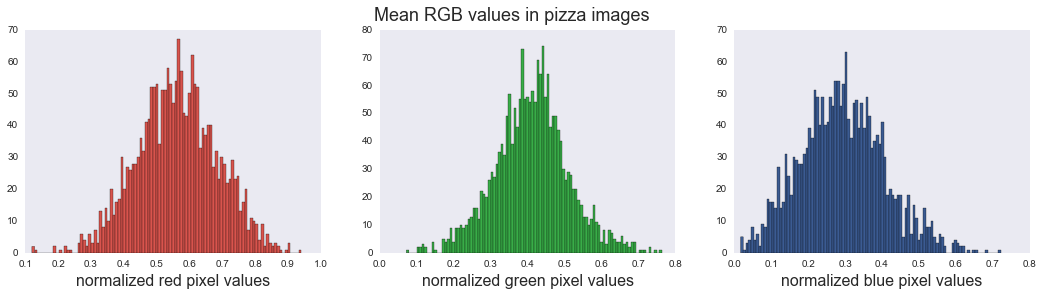

In [6]:
sns.set_style("dark")
fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.despine()

sns.distplot(img_info.red[img_info.label == 1], 
             bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["pale red"]}, ax=ax[0])
ax[0].set_xlabel('normalized red pixel values', size = 16, )

sns.distplot(img_info.green[img_info.label == 1], 
             bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["medium green"]}, ax=ax[1])
ax[1].set_xlabel('normalized green pixel values', size = 16)

sns.distplot(img_info.blue[img_info.label == 1], 
             bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["denim blue"]}, ax=ax[2])
ax[2].set_xlabel('normalized blue pixel values', size = 16)

plt.suptitle('Mean RGB values in pizza images', size=18)
plt.show()

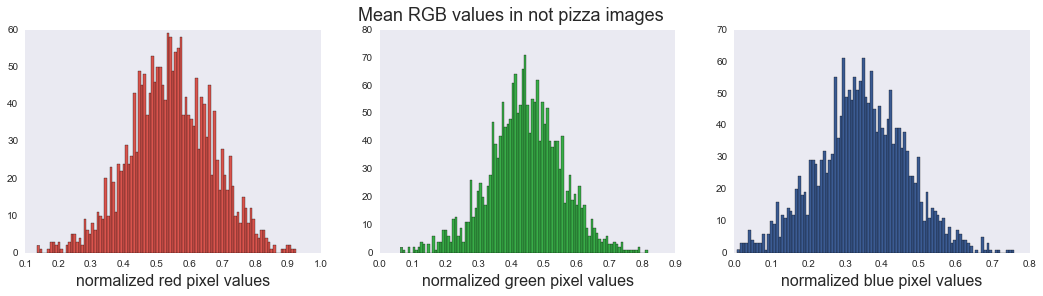

In [7]:
sns.set_style("dark")
fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.despine()

sns.distplot(img_info.red[img_info.label == 0], 
             bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["pale red"]}, ax=ax[0])
ax[0].set_xlabel('normalized red pixel values', size = 16)

sns.distplot(img_info.green[img_info.label == 0], 
             bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["medium green"]}, ax=ax[1])
ax[1].set_xlabel('normalized green pixel values', size = 16)

sns.distplot(img_info.blue[img_info.label == 0], 
             bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["denim blue"]}, ax=ax[2])
ax[2].set_xlabel('normalized blue pixel values', size = 16)

plt.suptitle('Mean RGB values in not pizza images', size=18)
plt.show()

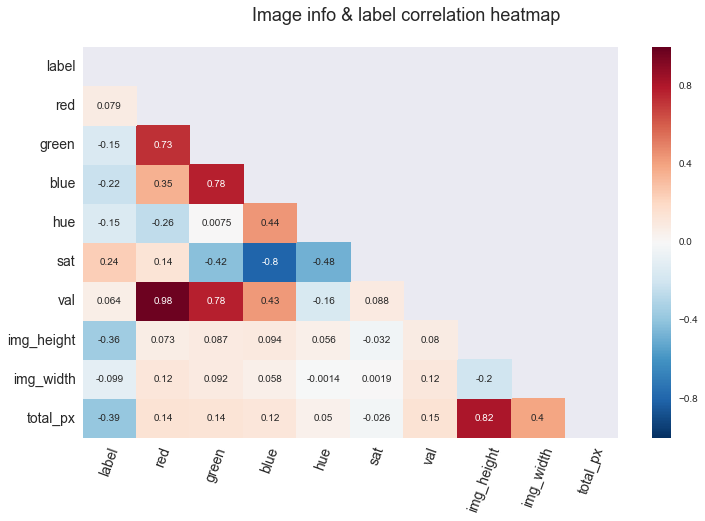

In [8]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(12,7))
mask = np.zeros_like(img_info.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(img_info.corr(), mask=mask, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=70)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
plt.suptitle('Image info & label correlation heatmap', size=18)
plt.show()

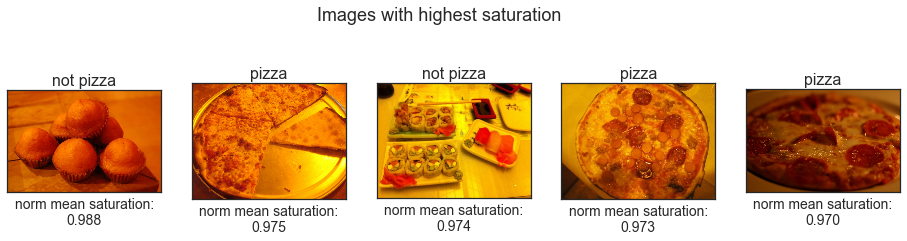

In [9]:
sat_df = img_info.sort_values('sat', ascending=False)
img_plots(4, sat_df['full_path'], sat_df.label, "norm mean saturation:", sat_df.sat, 'Images with highest saturation')

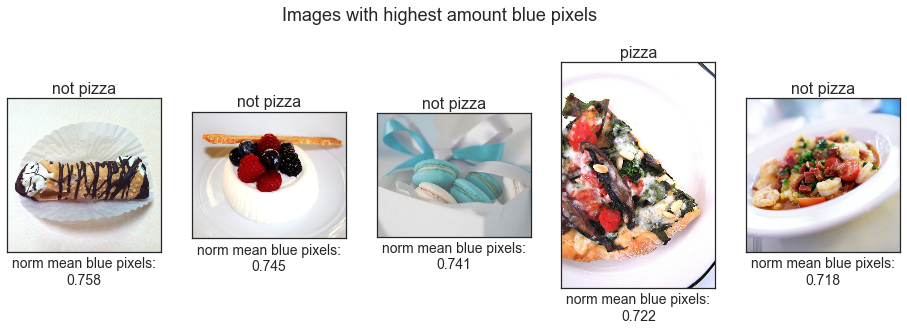

In [10]:
blue_df = img_info.sort_values('blue', ascending=False)
img_plots(5, blue_df['full_path'], blue_df.label, "norm mean blue pixels:", blue_df.blue, 
          'Images with highest amount blue pixels')

---
## <a name="4">Image preprocessing</a>
There was no data cleaning other than [organizing the images](data_setup.ipynb) into correct directory structure required for the keras method `.flow_from_directory` but there was some image preprocessing using the ImageDataGenerator class. The goal with the preprocessing is to make the most of few training examples and "augment" via random transformations so model never sees the same image twice which helps prevent overfitting and model to generalize better.

You can standardize pixel values across all the image data by using feature standardization which is similar to standardization performed on each column in a dataframe.

You can perform feature standardization by setting the featurewise_center and featurewise_std_normalization arguments on the ImageDataGenerator class. These are in fact set to True by default and creating an instance of ImageDataGenerator with no arguments will have the same effect.

When using deep convolutional neural networks (CNNs) for image classification tasks, it’s common to apply several transformations to the images in order to augment the data and reduce overfitting. For example, images are often randomly cropped, mirrored, rotated, and blurred to artificially increase the number of training examples. It’s much more efficient to do this in real-time rather than store extra transformed images on disk.

Large image datasets that won’t fit in memory all at once are loaded into GPU memory one batch at a time during training. Data augmentation steps are usually applied on the CPU. In Python, generators are often used to do this iteration over batches. For example,

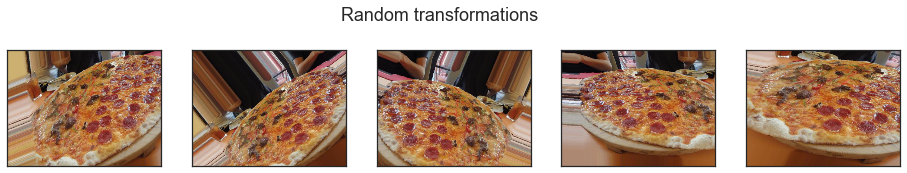

In [11]:
sns.set_style("white")
fig, ax = plt.subplots(1,5,figsize=(16,3))

pizza_transformed = [f for f in glob.glob('./transformations/*') if f.endswith('.jpg')]
images_plot = []

for img in pizza_transformed[:5]:
    image = cv2.imread(img)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_plot.append(image_rgb)
    
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(images_plot[i])

plt.suptitle('Random transformations', size=18)
plt.show() 

---
## <a name="4">Modeling</a>
Since images are high dimensional data it means there are many, many parameters so more simple modeling methods are not designed to handle this well. Convolution neural networks are well suited for computer vision tasks, so I'll be training a small network from scratch to predict the probability an image is of pizza.

For modeling I utilized Keras running on top Tensorflow on a AWS EC2 instance. I use the main type of model — a Sequential model, which is a linear stack of layers. Once defined, I compile the model where I specify the loss function and the optimizer to be used ('binary_crossentropy' and 'rmsprop'). After compiled, the model is fit to data on image generator functions for train and validation data.

### Load previousuly trained model

In [12]:
# path to images for .flow_from_directory() to pass in images
validation_data_dir = '/Users/VanessaG/Desktop/pizza_class_data/validation'

# resize images to these dimensions
img_width, img_height = 150, 150

# augmented image generator for validation set - really only rescaling here
test = ImageDataGenerator(
    rescale=1./255)

# generates validation images
validation_generator = test.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        shuffle=False,
        class_mode='binary')

Found 800 images belonging to 2 classes.


In [13]:
# load json and create model
json_file = open('pizza_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [14]:
# load weights into new model
loaded_model.load_weights("weights.best.hdf5")

In [15]:
# compile loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

---

## <a name="6">Results</a>

During each epoch the parameters (ie convolution, pooling filters) of the model are adjusted to minimize the loss function. The result are the weights which have the ability to generalize the model to new data it's not yet seen — this ability is reflected in the validation accuracy. Every epoch is essentially its own model - the accuracy can improve or decline if trained for another epoch so averaging the accuracy over the total epochs doesn't make much sense.

If the training data accuracy keeps improving while validation data accuracy gets worse, likely in an overfitting situation. The training loss also drops due to over-fitting, which is why validation loss is key.

### Validation accuracy & loss across epochs

In [16]:
# load model history object
fileObject = open('model_history','r')  
history = pickle.load(fileObject)  

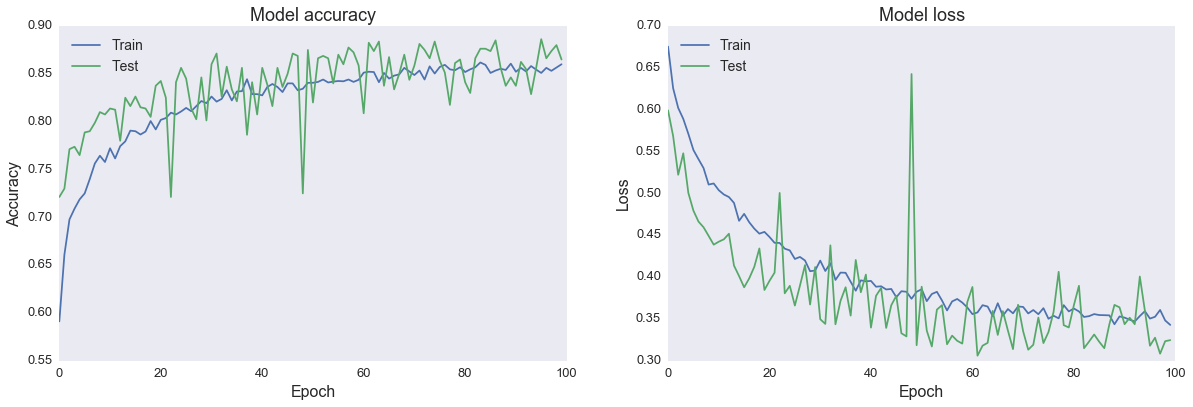

In [39]:
# A plot of accuracy and loss on the training and validation datasets over training epochs.
epoch_plot()

### Predictive power

In [18]:
loaded_model.evaluate_generator(validation_generator, 800, max_q_size=10, nb_worker=1)

[0.31805022100838803, 0.88249999999999995]

In [19]:
predictions = []
predicted_labels = []
for i, (img, y) in enumerate(validation_generator):
    if i >= 800:
        break
    pp = loaded_model.predict(img)
    label = int(pp[0] >= 0.5)
    predictions.append(pp[0][0])
    predicted_labels.append(label)  

In [20]:
pizzas = glob.glob(validation_data_dir+'/pizza/*.jpg')
not_pizzas = glob.glob(validation_data_dir+'/not_pizza/*.jpg')

In [21]:
image_file_predictions = {}

for i, filename in enumerate(not_pizzas+pizzas):
    image_file_predictions[filename] = {
        'predicted_prob_pizza':predictions[i],
        'predicted_label':predicted_labels[i]
    }

In [22]:
predictions_df = pd.DataFrame(image_file_predictions)
predictions_df = predictions_df.T.reset_index()

In [23]:
predictions_df.columns = ['filepath','predicted_label','predicted_prob_pizza']
predictions_df['actual_label'] = predictions_df.filepath.map(lambda x: 0 if '/not_pizza/' in x else 1)

In [24]:
predictions_df.head()

,filepath,predicted_label,predicted_prob_pizza,actual_label
0,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.643637,0
1,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.329799,0
2,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.150163,0
3,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.055289,0
4,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.425852,0


### Confusion Matrix

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [45]:
cnf_matrix = confusion_matrix(predictions_df.actual_label, predictions_df.predicted_label)
cnf_matrix

array([[359,  41],
       [ 55, 345]])

In [47]:
class_names = validation_generator.class_indices
class_names

{'not_pizza': 0, 'pizza': 1}

Confusion matrix, without normalization
[[359  41]
 [ 55 345]]


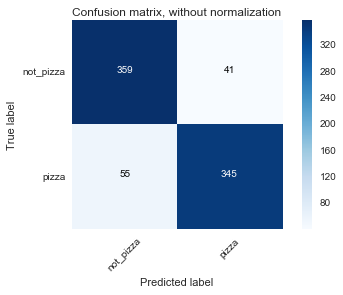

In [52]:
# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

In [29]:
print(classification_report(predictions_df['actual_label'], predictions_df['predicted_label']))

             precision    recall  f1-score   support

          0       0.87      0.90      0.88       400
          1       0.89      0.86      0.88       400

avg / total       0.88      0.88      0.88       800



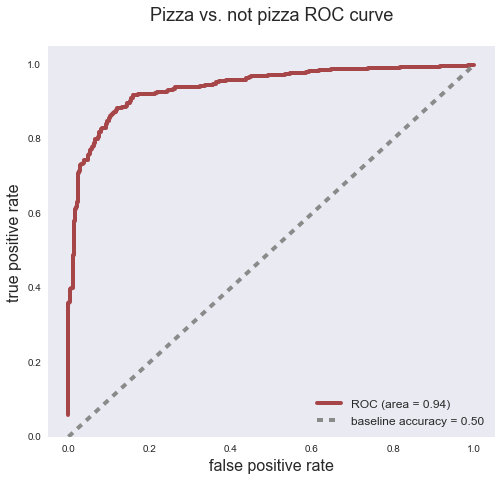

In [40]:
sns.set_style("dark")

fpr_, tpr_, _ = roc_curve(predictions_df['actual_label'], predictions_df['predicted_prob_pizza'])
auc_ = auc(fpr_, tpr_)
acc_ = np.abs(0.5 - np.mean(predictions_df['actual_label'])) + 0.5

fig, axr = plt.subplots(figsize=(8,7))

axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
         color='darkred', linewidth=4,
         alpha=0.7)
axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
         alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)

axr.set_xlim([-0.05, 1.05])
axr.set_ylim([0.0, 1.05])
axr.set_xlabel('false positive rate', fontsize=16)
axr.set_ylabel('true positive rate', fontsize=16)
axr.set_title('Pizza vs. not pizza ROC curve\n', fontsize=18)

axr.legend(loc="lower right", fontsize=12)

plt.show()

In [33]:
worst.head()

,filepath,predicted_label,predicted_prob_pizza,actual_label
362,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.928705,0
200,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.919995,0
236,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.896970,0
16,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.893120,0
357,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.829567,0


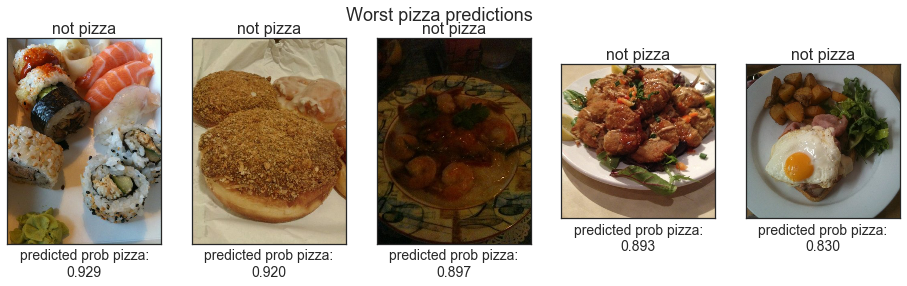

In [43]:
worst = predictions_df[(predictions_df.predicted_label == 1.00) & 
              (predictions_df.actual_label == 0)].sort_values('predicted_prob_pizza', ascending=False)

img_plots(4, worst['filepath'], worst.actual_label, "predicted prob pizza:", worst.predicted_prob_pizza,
              'Worst pizza predictions')

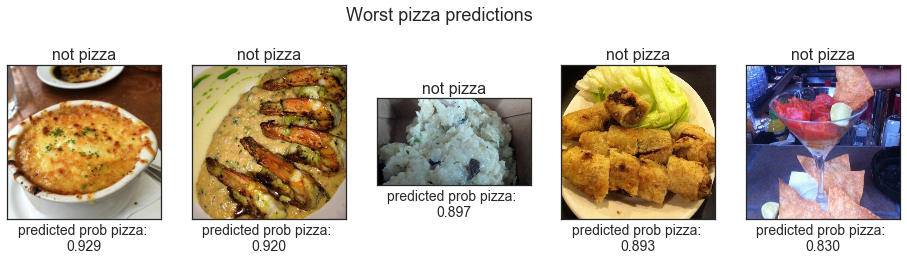

In [55]:
sns.set_style("white")
fig, ax = plt.subplots(1,5,figsize=(16,4))


worst = predictions_df[(predictions_df.predicted_class == 1.00) & 
              (predictions_df.actual_label == 0)].sort_values('predicted_prob_pizza', ascending=False)
images_plot = []

for img in worst['filepath'][:5]:
    image = cv2.imread(img)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_plot.append(image_rgb)
    
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(images_plot[i])
    label = 'not pizza' if worst.actual_label.values[i] == 0 else 'pizza'
    plt.title(label, size=16)
    plt.xlabel("predicted prob pizza: \n%.3f" % worst.predicted_prob_pizza.values[i], size=14)

plt.suptitle('Worst pizza predictions', size=18)
plt.show()     

In [36]:
best.head()

,filepath,predicted_label,predicted_prob_pizza,actual_label
507,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,1.0,1
557,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,1.0,1
440,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,1.0,1
605,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,1.0,1
745,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,1.0,1


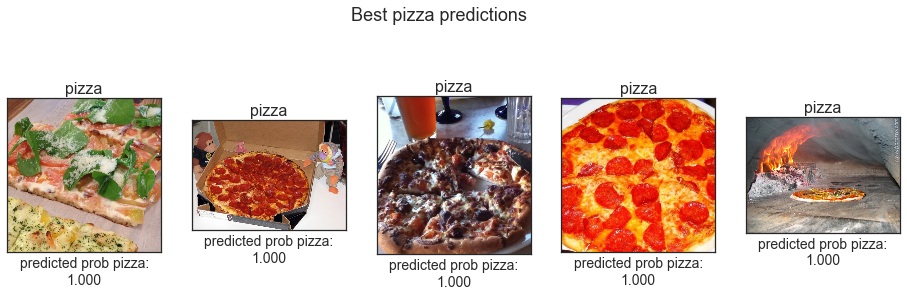

In [35]:
best = predictions_df[(predictions_df.predicted_label == 1.00) & 
              (predictions_df.actual_label == 1)].sort_values('predicted_prob_pizza', ascending=False)
img_plots(5, best['filepath'], best.actual_label, "predicted prob pizza:", best.predicted_prob_pizza, 
          'Best pizza predictions')

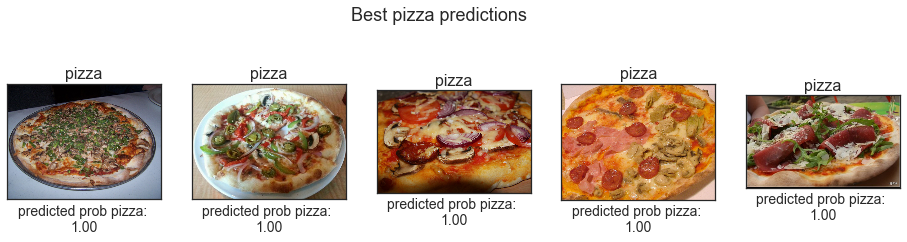

In [54]:
sns.set_style("white")
fig, ax = plt.subplots(1,5,figsize=(16,4))

best = predictions_df[(predictions_df.predicted_class == 1.00) & 
              (predictions_df.actual_label == 1)].sort_values('predicted_prob_pizza', ascending=False)
images_plot = []

for img in best['filepath'][:5]:
    image = cv2.imread(img)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_plot.append(image_rgb)
    
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(images_plot[i])
    label = 'not pizza' if best.actual_label.values[i] == 0 else 'pizza'
    plt.title(label, size=16)
    plt.xlabel("predicted prob pizza: \n%.2f" % best.predicted_prob_pizza.values[i], size=14)

plt.suptitle('Best pizza predictions', size=18)
plt.show() 

In [226]:
from keras.preprocessing import image as image_utils
image = '/Users/VanessaG/Desktop/pizza_class_data/train/not_pizza/101675.jpg'
image = image_utils.load_img(image, target_size=(150, 150))
image = image_utils.img_to_array(image)
image = image.reshape((1,) + image.shape)  

In [227]:
loaded_model.predict_classes(image)

1/1 [==============================] - 0s


array([[0]], dtype=int32)

In [228]:
loaded_model.predict_proba(image)

1/1 [==============================] - 0s


array([[ 0.]], dtype=float32)